In [23]:
# Cell 1: Import cơ bản
import cv2
import numpy as np
from skimage.metrics import structural_similarity as ssim
import pytesseract
import os
import matplotlib.pyplot as plt
from difflib import SequenceMatcher

In [24]:
pytesseract.pytesseract.tesseract_cmd = r'D:\Apps\Tesseract-OCR\tesseract.exe'

In [25]:
# Cell 2: Core Algorithm - Đơn giản và hiệu quả
class VisualTester:
    """Giải pháp kiểm thử giao diện đơn giản"""
    
    def preprocess(self, img_path):
        """Tiền xử lý ảnh chuẩn"""
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        if img is None:
            return None
        # Resize và khử nhiễu
        img = cv2.resize(img, (800, 600))
        img = cv2.fastNlMeansDenoising(img)
        return img
    
    def compare_visual(self, img1_path, img2_path):
        """So sánh visual bằng SSIM"""
        img1 = self.preprocess(img1_path)
        img2 = self.preprocess(img2_path)
        
        if img1 is None or img2 is None:
            return 0
        
        # Tính SSIM score
        score = ssim(img1, img2)
        return score * 100  # Convert to percentage
    
    def compare_text(self, img1_path, img2_path):
        """So sánh text bằng OCR"""
        try:
            text1 = pytesseract.image_to_string(cv2.imread(img1_path)).strip()
            text2 = pytesseract.image_to_string(cv2.imread(img2_path)).strip()
            
            # Text similarity
            similarity = SequenceMatcher(None, text1, text2).ratio()
            return similarity * 100
        except:
            return 0
    
    def test_similarity(self, img1_path, img2_path, show_details=True):
        """Main testing function"""
        visual_score = self.compare_visual(img1_path, img2_path)
        text_score = self.compare_text(img1_path, img2_path)
        
        # Combined score (70% visual, 30% text)
        combined_score = (visual_score * 0.7) + (text_score * 0.3)
        
        # Decision
        is_similar = combined_score > 80
        
        if show_details:
            print(f"Testing: {os.path.basename(img1_path)} vs {os.path.basename(img2_path)}")
            print(f"Visual: {visual_score:.1f}%")
            print(f"Text: {text_score:.1f}%")
            print(f"Combined: {combined_score:.1f}%")
            print(f"Result: {'SIMILAR' if is_similar else 'DIFFERENT'}")
            print()
        
        return {
            'visual': visual_score,
            'text': text_score,
            'combined': combined_score,
            'similar': is_similar
        }

# Initialize tester
tester = VisualTester()
print("VisualTester ready!")

VisualTester ready!


In [26]:
# Cell 3: Quick Test Function
def quick_test(img1, img2):
    """Test nhanh 2 ảnh"""
    if not os.path.exists(img1):
        print(f"Not found: {img1}")
        return
    if not os.path.exists(img2):
        print(f"Not found: {img2}")
        return
    
    result = tester.test_similarity(img1, img2)
    return result

In [27]:
# Cell 4: Batch Testing với Dataset
def evaluate_algorithm(test_cases):
    """
    Đánh giá thuật toán trên nhiều test cases
    
    test_cases format:
    [
        ("original1.jpg", "similar1.jpg", "similar"),
        ("original1.jpg", "different1.jpg", "different"),
        ...
    ]
    """
    total = len(test_cases)
    correct = 0
    results = []
    
    print(f"Testing {total} cases...")
    print("="*50)
    
    for i, (img1, img2, expected) in enumerate(test_cases, 1):
        print(f"Test {i}/{total}: ", end="")
        
        result = tester.test_similarity(img1, img2, show_details=False)
        predicted = "similar" if result['similar'] else "different"
        is_correct = predicted == expected
        
        if is_correct:
            correct += 1
            
        print(f"{os.path.basename(img2)} -> {predicted} ({'✅' if is_correct else '❌'})")
        
        results.append({
            'test_id': i,
            'expected': expected,
            'predicted': predicted,
            'score': result['combined'],
            'correct': is_correct
        })
    
    accuracy = (correct / total) * 100
    
    print("\nRESULTS:")
    print(f"   Total tests: {total}")
    print(f"   Correct: {correct}")
    print(f"   Accuracy: {accuracy:.1f}%")
    
    return results, accuracy

In [28]:
# Cell 5: Find Best Threshold
def find_best_threshold(test_cases):
    """Tìm threshold tối ưu"""
    thresholds = [70, 75, 80, 85, 90, 95]
    best_accuracy = 0
    best_threshold = 80
    
    print("Finding optimal threshold...")
    
    for threshold in thresholds:
        correct = 0
        
        for img1, img2, expected in test_cases:
            result = tester.test_similarity(img1, img2, show_details=False)
            predicted = "similar" if result['combined'] > threshold else "different"
            if predicted == expected:
                correct += 1
        
        accuracy = (correct / len(test_cases)) * 100
        print(f"   Threshold {threshold}%: {accuracy:.1f}% accuracy")
        
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_threshold = threshold
    
    print(f"\nBest threshold: {best_threshold}% (Accuracy: {best_accuracy:.1f}%)")
    return best_threshold, best_accuracy

In [29]:
# Cell 6: Simple Visualization
def plot_results(results):
    """Vẽ biểu đồ kết quả đơn giản"""
    scores = [r['score'] for r in results]
    correct = [r['correct'] for r in results]
    
    # Score distribution
    plt.figure(figsize=(10, 4))
    
    plt.subplot(1, 2, 1)
    colors = ['green' if c else 'red' for c in correct]
    plt.scatter(range(len(scores)), scores, c=colors, alpha=0.7)
    plt.axhline(y=80, color='blue', linestyle='--', label='Threshold')
    plt.xlabel('Test Case')
    plt.ylabel('Combined Score (%)')
    plt.title('Test Results (Green=Correct, Red=Wrong)')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.subplot(1, 2, 2)
    plt.hist(scores, bins=10, alpha=0.7, color='blue', edgecolor='black')
    plt.axvline(x=80, color='red', linestyle='--', label='Threshold')
    plt.xlabel('Combined Score (%)')
    plt.ylabel('Frequency')
    plt.title('Score Distribution')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

🔧 Starting comprehensive evaluation...
COMPREHENSIVE VISUAL TESTING EVALUATION
Found Pictures_VisualTesting folder
Found 7 original images
original_1: 3 variants
original_2: 3 variants
original_3: 3 variants
original_4: 3 variants
original_5: 3 variants
original_6: 3 variants
original_7: 3 variants

Generated 21 test cases:
   ✅ Similar cases: 14 (variant_1 + variant_2)
   ❌ Different cases: 7 (variant_3)
   ❓ Unknown cases: 0

🔍 Test Cases by Original:

📸 original_1.png:
   └── vs variant_1.png → similar
   └── vs variant_2.png → similar
   └── vs variant_3.png → different

📸 original_2.png:
   └── vs variant_1.png → similar
   └── vs variant_2.png → similar
   └── vs variant_3.png → different

📸 original_3.png:
   └── vs variant_1.png → similar
   └── vs variant_2.png → similar
   └── vs variant_3.png → different

📸 original_4.png:
   └── vs variant_1.png → similar
   └── vs variant_2.png → similar
   └── vs variant_3.png → different

📸 original_5.png:
   └── vs variant_1.png → simil

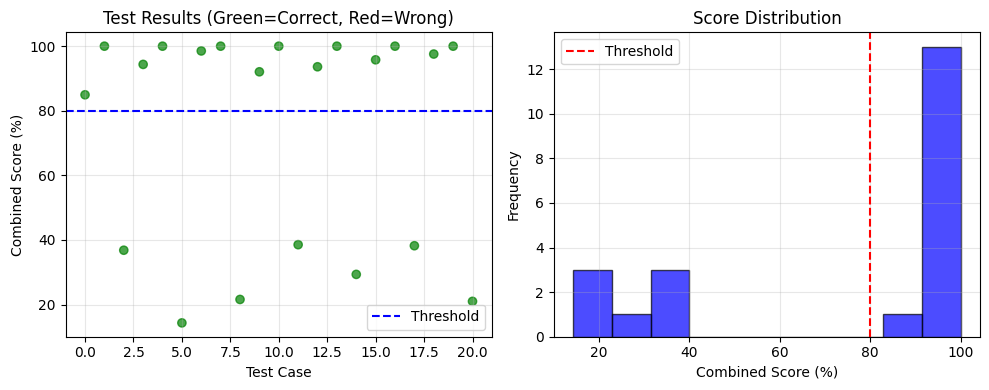


🔧 OPTIMIZING THRESHOLD...
Finding optimal threshold...
   Threshold 70%: 100.0% accuracy
   Threshold 75%: 100.0% accuracy
   Threshold 80%: 100.0% accuracy
   Threshold 85%: 95.2% accuracy
   Threshold 90%: 95.2% accuracy
   Threshold 95%: 81.0% accuracy

Best threshold: 70% (Accuracy: 100.0%)

🎉 COMPREHENSIVE EVALUATION COMPLETED!
📊 FINAL SUMMARY:
   💯 Overall Accuracy: 100.0%
   🎯 Best Threshold: 70%
   📈 Optimized Accuracy: 100.0%
   🟢 Similar Detection: 100.0% (variant_1 + variant_2)
   🔴 Different Detection: 100.0% (variant_3)

🎉 PERFECT PERFORMANCE! All tests passed!


In [30]:
# Cell 7: Auto Test Cases Generation cho cấu trúc thư mục mới
import os
import re

def auto_generate_test_cases_v2(original_dir, variant_dir):
    """Tự động tạo test cases từ cấu trúc thư mục mới"""
    test_cases = []
    
    if not os.path.exists(original_dir) or not os.path.exists(variant_dir):
        print("Thư mục không tồn tại!")
        return test_cases
    
    # Lấy danh sách ảnh original
    original_files = [f for f in os.listdir(original_dir) 
                     if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
    
    print(f"Found {len(original_files)} original images")
    
    for original_file in original_files:
        # Extract số từ tên file (ví dụ: original_1.png -> 1)
        match = re.search(r'original_(\d+)', original_file)
        if not match:
            continue
        
        original_num = match.group(1)
        original_path = os.path.join(original_dir, original_file)
        
        # Tìm thư mục variant tương ứng
        variant_folder = os.path.join(variant_dir, f"original_{original_num}")
        
        if not os.path.exists(variant_folder):
            print(f"Missing variant folder: original_{original_num}")
            continue
        
        # Lấy các variant trong thư mục
        variant_files = [f for f in os.listdir(variant_folder) 
                        if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
        
        print(f"original_{original_num}: {len(variant_files)} variants")
        
        for variant_file in variant_files:
            variant_path = os.path.join(variant_folder, variant_file)
            
            # Phân loại dựa trên tên file
            if 'variant_1' in variant_file:
                expected = "similar"      # Có thay đổi nhỏ -> similar
            elif 'variant_2' in variant_file:  
                expected = "similar"      # Tương tự gốc -> similar
            elif 'variant_3' in variant_file:
                expected = "different"    # Khác biệt hoàn toàn -> different
            else:
                expected = "unknown"      # Không xác định
            
            test_cases.append((original_path, variant_path, expected))
    
    return test_cases

def run_comprehensive_evaluation():
    """Chạy đánh giá toàn diện với cấu trúc mới"""
    
    print("COMPREHENSIVE VISUAL TESTING EVALUATION")
    print("="*60)
    
    # Kiểm tra thư mục
    if not os.path.exists("Pictures_VisualTesting"):
        print("Pictures_VisualTesting folder not found!")
        return
    
    print("Found Pictures_VisualTesting folder")
    
    # Tự động tạo test cases
    original_dir = "Pictures_VisualTesting/original_image/"
    variant_dir = "Pictures_VisualTesting/variant_image/"
    
    test_cases = auto_generate_test_cases_v2(original_dir, variant_dir)
    
    if not test_cases:
        print("No test cases generated!")
        return
    
    print(f"\nGenerated {len(test_cases)} test cases:")

    # Phân loại theo expected result
    similar_cases = [tc for tc in test_cases if tc[2] == "similar"]
    different_cases = [tc for tc in test_cases if tc[2] == "different"]
    unknown_cases = [tc for tc in test_cases if tc[2] == "unknown"]
    
    print(f"   ✅ Similar cases: {len(similar_cases)} (variant_1 + variant_2)")
    print(f"   ❌ Different cases: {len(different_cases)} (variant_3)")
    print(f"   ❓ Unknown cases: {len(unknown_cases)}")
    
    # Preview test cases theo original
    print(f"\n🔍 Test Cases by Original:")
    current_original = None
    for original_path, variant_path, expected in test_cases:
        original_name = os.path.basename(original_path)
        variant_name = os.path.basename(variant_path)
        
        if original_name != current_original:
            current_original = original_name
            print(f"\n📸 {original_name}:")
        
        print(f"   └── vs {variant_name} → {expected}")
    
    print(f"\n" + "="*60)
    print("STARTING DETAILED EVALUATION")
    print("="*60)
    
    # 1. Quick test mẫu từ mỗi category
    print(f"\nQUICK TESTS BY CATEGORY:")
    
    if similar_cases:
        print(f"\nSimilar Case Sample:")
        sample_similar = quick_test(similar_cases[0][0], similar_cases[0][1])
    
    if different_cases:
        print(f"\nDifferent Case Sample:")
        sample_different = quick_test(different_cases[0][0], different_cases[0][1])
    
    # 2. Chạy đánh giá đầy đủ
    print(f"\nRUNNING FULL EVALUATION...")
    results, overall_accuracy = evaluate_algorithm(test_cases)
    
    # 3. Phân tích chi tiết theo category
    print(f"\nDETAILED ANALYSIS BY CATEGORY:")
    
    # Phân tích Similar cases (variant_1 + variant_2)
    similar_results = [r for r in results if r['expected'] == 'similar']
    if similar_results:
        similar_correct = sum(1 for r in similar_results if r['correct'])
        similar_accuracy = similar_correct / len(similar_results) * 100
        similar_avg_score = sum(r['score'] for r in similar_results) / len(similar_results)
        
        print(f"   🟢 SIMILAR CASES (variant_1 + variant_2):")
        print(f"      📊 Count: {len(similar_results)}")
        print(f"      🎯 Accuracy: {similar_accuracy:.1f}%")
        print(f"      📈 Avg Score: {similar_avg_score:.1f}%")
    
    # Phân tích Different cases (variant_3)
    different_results = [r for r in results if r['expected'] == 'different']
    if different_results:
        different_correct = sum(1 for r in different_results if r['correct'])
        different_accuracy = different_correct / len(different_results) * 100
        different_avg_score = sum(r['score'] for r in different_results) / len(different_results)
        
        print(f"   🔴 DIFFERENT CASES (variant_3):")
        print(f"      📊 Count: {len(different_results)}")
        print(f"      🎯 Accuracy: {different_accuracy:.1f}%")
        print(f"      📈 Avg Score: {different_avg_score:.1f}%")
    
    # 4. Phân tích theo từng Original
    print(f"\n📈 ANALYSIS BY ORIGINAL IMAGE:")
    original_stats = {}
    for result in results:
        original_name = os.path.basename(test_cases[result['test_id']-1][0])
        if original_name not in original_stats:
            original_stats[original_name] = {'total': 0, 'correct': 0, 'scores': []}
        
        original_stats[original_name]['total'] += 1
        if result['correct']:
            original_stats[original_name]['correct'] += 1
        original_stats[original_name]['scores'].append(result['score'])
    
    for original_name, stats in original_stats.items():
        accuracy = stats['correct'] / stats['total'] * 100
        avg_score = sum(stats['scores']) / len(stats['scores'])
        print(f"   📸 {original_name}: {accuracy:.1f}% accurate (avg score: {avg_score:.1f}%)")
    
    # 5. Visualization
    print(f"\n📈 CREATING VISUALIZATIONS...")
    plot_results(results)
    
    # 6. Threshold optimization
    print(f"\n🔧 OPTIMIZING THRESHOLD...")
    best_threshold, best_accuracy = find_best_threshold(test_cases)
    
    # 7. Final summary
    print(f"\n🎉 COMPREHENSIVE EVALUATION COMPLETED!")
    print(f"📊 FINAL SUMMARY:")
    print(f"   💯 Overall Accuracy: {overall_accuracy:.1f}%")
    print(f"   🎯 Best Threshold: {best_threshold}%")
    print(f"   📈 Optimized Accuracy: {best_accuracy:.1f}%")
    
    if similar_results:
        print(f"   🟢 Similar Detection: {similar_accuracy:.1f}% (variant_1 + variant_2)")
    if different_results:
        print(f"   🔴 Different Detection: {different_accuracy:.1f}% (variant_3)")
    
    # 8. Failed cases analysis
    wrong_cases = [r for r in results if not r['correct']]
    if wrong_cases:
        print(f"\n🔍 FAILED CASES ANALYSIS:")
        for case in wrong_cases:
            original_path, variant_path, expected = test_cases[case['test_id']-1]
            original_name = os.path.basename(original_path)
            variant_name = os.path.basename(variant_path)
            print(f"   ❌ {original_name} vs {variant_name}")
            print(f"      Expected: {case['expected']}, Got: {case['predicted']}")
            print(f"      Score: {case['score']:.1f}% (threshold: 80%)")
    else:
        print(f"\n🎉 PERFECT PERFORMANCE! All tests passed!")
    
    return test_cases, results, overall_accuracy

# Chạy đánh giá toàn diện
print("🔧 Starting comprehensive evaluation...")
test_cases, results, accuracy = run_comprehensive_evaluation()